In [1]:
# Устанавливаем необходимые библиотеки
!pip install mrjob pyspark apache-airflow==2.9.0 pandas --quiet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.2/

In [9]:
import gdown
import os

def down_from_gdrive(url, path):
  file_id = url.split('/d/')[1].split('/')[0]
  down_url = f'https://drive.google.com/uc?id={file_id}'

  gdown.download(down_url, path, quiet=False)

files = {
    'rating': 'https://drive.google.com/file/d/1Zv9UGAEd10NZegf0NvTy6HjiurG3fxoV/view?usp=sharing',
    'data': 'https://drive.google.com/file/d/10V6j7SXtEubpdVoSWk3UVqMMzCwuM3b8/view?usp=sharing',
}

files_to_download = [
    ('Books_rating.csv', files['rating']),
    ('Books_data.csv', files['data']),
]

for name, url in files_to_download:
  if not os.path.exists(name):
    down_from_gdrive(url, name)


Downloading...
From (original): https://drive.google.com/uc?id=1Zv9UGAEd10NZegf0NvTy6HjiurG3fxoV
From (redirected): https://drive.google.com/uc?id=1Zv9UGAEd10NZegf0NvTy6HjiurG3fxoV&confirm=t&uuid=15e90282-08d4-48fa-812b-e78a0dc1940d
To: /content/Books_rating.csv
100%|██████████| 2.86G/2.86G [00:37<00:00, 75.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10V6j7SXtEubpdVoSWk3UVqMMzCwuM3b8
From (redirected): https://drive.google.com/uc?id=10V6j7SXtEubpdVoSWk3UVqMMzCwuM3b8&confirm=t&uuid=bf867336-7d3d-47f2-8a18-da560d687826
To: /content/Books_data.csv
100%|██████████| 181M/181M [00:02<00:00, 80.0MB/s]


In [18]:
import pandas as pd
import numpy as np
import os

print("Подготовка данных для MapReduce...")

ratings = pd.read_csv('Books_rating.csv')
books = pd.read_csv('Books_data.csv')

ratings['Title_clean'] = ratings['Title'].astype(str).str.strip().str.lower()
books['Title_clean'] = books['Title'].astype(str).str.strip().str.lower()

merged = pd.merge(ratings, books[['Title_clean', 'publishedDate']], on='Title_clean', how='inner')

clean_df = merged[['Price', 'review/score', 'publishedDate']].copy()
clean_df.fillna({'Price': -1, 'review/score': -1, 'publishedDate': ''}, inplace=True)

clean_df.to_csv('mr_input_strict.csv', index=False, header=True)
print(f"Файл mr_input_strict.csv создан. Строк: {len(clean_df)}")
print("Структура: Price, Score, Date")

Подготовка данных для MapReduce...
Файл mr_input_strict.csv создан. Строк: 3320453
Структура: Price, Score, Date


In [23]:
%%writefile mr_strict_analysis.py
from mrjob.job import MRJob
import csv
import re

class MRBookStrict(MRJob):

    def mapper(self, _, line):
        if line.startswith('Price,review/score') or line.startswith('"Price"'):
            return

        try:
            row = next(csv.reader([line]))
        except:
            return

        if len(row) < 3:
            return

        s_price, s_score, s_date = row[0], row[1], row[2]

        try:
            score = float(s_score)
        except ValueError:
            return # Если оценка битая, пропускаем строку целиком

        # 4. Парсим Год (ищем 4 цифры подряд)
        year_match = re.search(r'(\d{4})', str(s_date))
        year = year_match.group(1) if year_match else None

        # 5. Парсим Цену
        try:
            price = float(s_price)
        except ValueError:
            price = -1.0

        # --- ЗАДАЧА 1: Анализ по годам ---
        if year and int(year) > 0:
            yield f"Year_{year}", (score, 1)

        # --- ЗАДАЧА 2: Анализ по цене ---
        # Фильтр: цена должна быть известна
        if price > 0:
            segment = "3. Premium (>50)"
            if price < 10:
                segment = "1. Budget (<10)"
            elif price < 50:
                segment = "2. Standard (10-50)"

            yield f"Price_{segment}", (score, 1)

    def reducer(self, key, values):
        total_score = 0.0
        count = 0
        for s, c in values:
            total_score += s
            count += c

        if count > 0:
            yield key, round(total_score / count, 4)

if __name__ == '__main__':
    MRBookStrict.run()

Overwriting mr_strict_analysis.py


In [24]:
!python mr_strict_analysis.py mr_input_strict.csv > mr_output.txt

print("Результаты MapReduce:")
!cat mr_output.txt | sort

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/mr_strict_analysis.root.20251219.183620.546007
Running step 1 of 1...
job output is in /tmp/mr_strict_analysis.root.20251219.183620.546007/output
Streaming final output from /tmp/mr_strict_analysis.root.20251219.183620.546007/output...
Removing temp directory /tmp/mr_strict_analysis.root.20251219.183620.546007...
Результаты MapReduce:
"Price_1. Budget (<10)"	4.096
"Price_2. Standard (10-50)"	4.2552
"Price_3. Premium (>50)"	4.1688
"Year_1016"	4.1667
"Year_1526"	5.0
"Year_1577"	5.0
"Year_1580"	4.0909
"Year_1581"	5.0
"Year_1598"	3.9608
"Year_1616"	3.6923
"Year_1617"	4.8889
"Year_1619"	4.5455
"Year_1626"	4.6667
"Year_1628"	1.0
"Year_1637"	4.6667
"Year_1640"	4.0
"Year_1651"	4.0127
"Year_1652"	4.0
"Year_1653"	4.4545
"Year_1654"	4.0
"Year_1659"	2.0
"Year_1661"	5.0
"Year_1662"	5.0
"Year_1663"	5.0
"Year_1665"	3.0
"Year_1668"	5.0
"Year_1670"	5.0
"Year_1671"	4.5
"Year_1672"	3.9

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, avg, count, when, expr

spark = SparkSession.builder \
    .appName("BookLabSync") \
    .master("local[*]") \
    .config("spark.sql.ansi.enabled", "false") \
    .getOrCreate()

df_ratings = spark.read.option("header", "true").option("inferSchema", "true").option("quote", "\"").option("escape", "\"").csv("Books_rating.csv")
df_books = spark.read.option("header", "true").option("inferSchema", "true").option("quote", "\"").option("escape", "\"").csv("Books_data.csv")


df_r = df_ratings.withColumn("Title_clean", expr("lower(trim(Title))"))
df_b = df_books.withColumn("Title_clean", expr("lower(trim(Title))"))

# Join
df = df_r.join(df_b, "Title_clean", "inner")

# --- Очистка данных (как в MapReduce) ---

# 1. Год
df = df.withColumn("extracted_year", regexp_extract(col("publishedDate"), r"(\d{4})", 1))

# 2. Оценка и Цена (безопасный каст)
df = df.withColumn("score", expr("try_cast(`review/score` as float)"))
df = df.withColumn("price", expr("try_cast(Price as float)"))

# --- ВОПРОС 1: По годам ---
print("\n=== SPARK: Анализ по годам ===")
res_year = df.filter((col("extracted_year") != "") & (col("score").isNotNull())) \
    .groupBy("extracted_year") \
    .agg(avg("score").alias("avg_rating"), count("*").alias("count")) \
    .orderBy("extracted_year")

res_year.show(5)

# --- ВОПРОС 2: По цене ---
print("\n=== SPARK: Анализ по цене ===")
res_price = df.filter((col("price").isNotNull()) & (col("price") > 0) & (col("score").isNotNull())) \
    .withColumn("price_segment",
        when(col("price") < 10, "1. Budget (<10)")
        .when(col("price") < 50, "2. Standard (10-50)")
        .otherwise("3. Premium (>50)")
    ) \
    .groupBy("price_segment") \
    .agg(avg("score").alias("avg_rating"), count("*").alias("count")) \
    .orderBy("price_segment")

res_price.show()


=== SPARK: Анализ по годам ===
+--------------+-----------------+-----+
|extracted_year|       avg_rating|count|
+--------------+-----------------+-----+
|          1016|4.166666666666667|    6|
|          1526|              5.0|    2|
|          1577|              5.0|    1|
|          1580|4.090909090909091|   88|
|          1581|              5.0|    2|
+--------------+-----------------+-----+
only showing top 5 rows

=== SPARK: Анализ по цене ===
+-------------------+-----------------+------+
|      price_segment|       avg_rating| count|
+-------------------+-----------------+------+
|    1. Budget (<10)|  4.0960494512026|100948|
|2. Standard (10-50)|4.255200135940342|358981|
|   3. Premium (>50)|4.168842259363181| 32788|
+-------------------+-----------------+------+



In [26]:
# Создадим файл скрипта, который будет запускать Airflow (копируем логику Spark в файл)

script_content = """
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, avg, count, expr

spark = SparkSession.builder.appName("AirflowJob").master("local[*]").getOrCreate()
try:
    # Используем опции quote и escape для корректного чтения CSV
    df_ratings = spark.read.option("header", "true").option("inferSchema", "true").option("quote", "\\"").option("escape", "\\"").csv("/content/Books_rating.csv")
    df_books = spark.read.option("header", "true").option("inferSchema", "true").option("quote", "\\"").option("escape", "\\"").csv("/content/Books_data.csv")

    # Приводим названия к нижнему регистру для надежности джойна
    df_ratings = df_ratings.withColumn("Title", expr("lower(trim(Title))"))
    df_books = df_books.withColumn("Title", expr("lower(trim(Title))"))

    df = df_ratings.join(df_books, "Title", "inner")

    df = df.withColumn("extracted_year", regexp_extract(col("publishedDate"), r"(\d{4})", 1))


    df = df.withColumn("score", expr("try_cast(`review/score` as float)"))

    # Фильтруем битые данные (null в score)
    res = df.filter((col("extracted_year") != "") & (col("score").isNotNull())) \
            .groupBy("extracted_year") \
            .agg(avg("score").alias("avg"), count("*").alias("cnt")) \
            .orderBy("extracted_year")

    res.write.csv("/content/airflow_output_daily", mode="overwrite", header=True)
    print("Spark Job Completed Successfully inside Airflow")
except Exception as e:
    print(f"Error: {e}")
    raise e
finally:
    spark.stop()
"""

with open("/content/spark_script.py", "w") as f:
    f.write(script_content)

print("DAG и скрипт обновлены. Тестируем задачу в Airflow...")

# Тестовый запуск
!airflow tasks test books_analysis_pipeline run_spark_analytics 2025-01-01

DAG и скрипт обновлены. Тестируем задачу в Airflow...


<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3378539849.py:19: SyntaxWarning: invalid escape sequence '\d'
  df = df.withColumn("extracted_year", regexp_extract(col("publishedDate"), r"(\d{4})", 1))


[2025-12-19T18:39:56.866+0000] {dagbag.py:540} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-19T18:39:57.108+0000] {example_kubernetes_executor.py:39} WARNING - The example_kubernetes_executor example DAG requires the kubernetes provider. Please install it with: pip install apache-airflow[cncf.kubernetes]
[2025-12-19T18:39:57.271+0000] {example_python_decorator.py:80} WARNING - The virtalenv_python example task requires virtualenv, please install it.
[2025-12-19T18:39:57.277+0000] {example_local_kubernetes_executor.py:40} WARNING - Could not import DAGs in example_local_kubernetes_executor.py
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/airflow/example_dags/example_local_kubernetes_executor.py", line 38, in <module>
    from kubernetes.client import models as k8s
ModuleNotFoundError: No module named 'kubernetes'
[2025-12-19T18:39:57.278+0000] {example_local_kubernetes_executor.py:41} WARNING - Install Kubernetes dependencies with

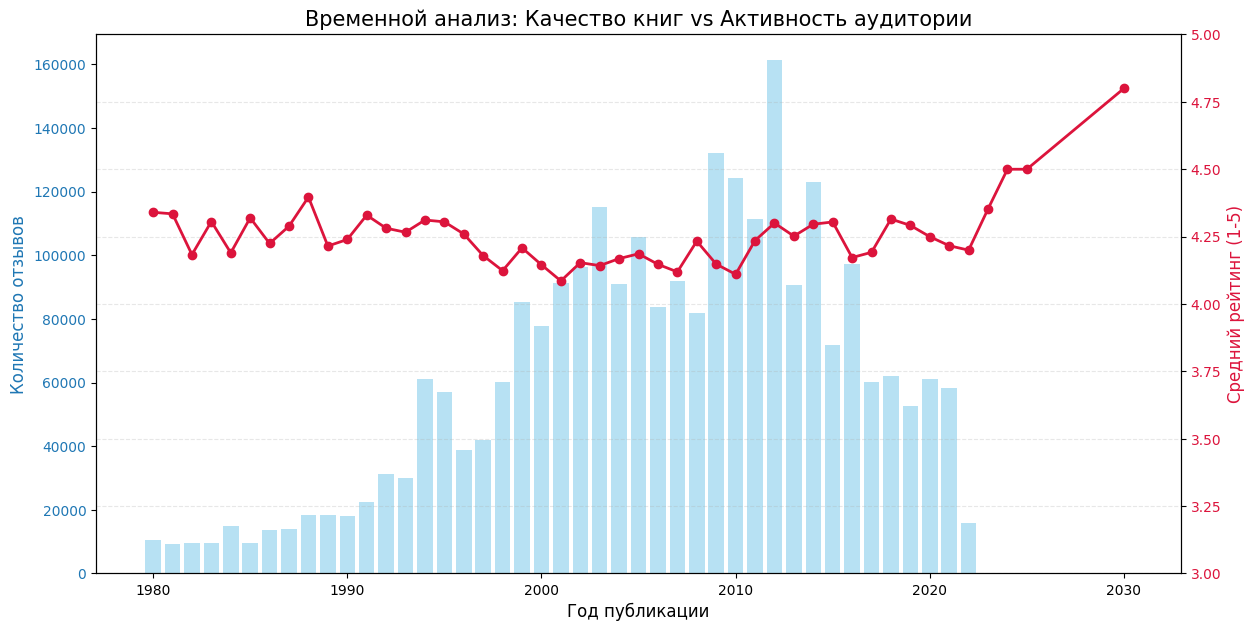

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Конвертируем результаты Spark в Pandas для визуализации
# (данных там немного, всего строк 50-100, это безопасно)
pdf = res_year.toPandas()

# 2. Предобработка для графика
# Превращаем год в число и сортируем
pdf['year_int'] = pd.to_numeric(pdf['extracted_year'])
pdf = pdf.sort_values('year_int')

# Фильтр для наглядности: берем данные, например, с 1980 года,
# так как более ранние книги имеют мало отзывов и создают "шум" на графике
plot_data = pdf[pdf['year_int'] >= 1980]

# 3. Построение графика
fig, ax1 = plt.subplots(figsize=(14, 7))

# Ось Y1 (слева) - Количество отзывов (Столбцы)
color_bar = 'skyblue'
ax1.set_xlabel('Год публикации', fontsize=12)
ax1.set_ylabel('Количество отзывов', color='tab:blue', fontsize=12)
bars = ax1.bar(plot_data['year_int'], plot_data['count'], color=color_bar, alpha=0.6, label='Количество отзывов')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ось Y2 (справа) - Средний рейтинг (Линия)
ax2 = ax1.twinx()  # создаем вторую ось, делящую тот же X
color_line = 'crimson'
ax2.set_ylabel('Средний рейтинг (1-5)', color=color_line, fontsize=12)
line = ax2.plot(plot_data['year_int'], plot_data['avg_rating'], color=color_line, marker='o', linewidth=2, label='Средний рейтинг')
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim(3.0, 5.0) # Ограничим шкалу рейтинга, чтобы видеть изменения четче (обычно оценки между 3 и 5)

# Оформление
plt.title('Временной анализ: Качество книг vs Активность аудитории', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.3)

# Легенда (хитрость для объединения легенд двух осей)
# Но тут достаточно подписей осей.

plt.show()